In [2]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

In [280]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/chirp_kagome_centralSource_2-16kHz_0802/raw/', 
                       frequencies = np.linspace(2000, 16000, 500), 
                       targetfile = '../../data/chirp_kagome_centralSource_2-16kHz_0802/preprocessed/', 
                       title = 'scppos_', setno = 0)

Found 377 records
Preprocessing complete!


In [10]:
## STEP 1.5: NORMALIZE SOUND INTENSITY BASED ON THE MIC'S FREQUENCY RESPONSE (OPTIONAL)
freqRespFile = "../../data/chirp_kagome_6-20kHz_0629/freq-response_6000_20000_500.pkl"
datafile = "../../data/chirp_kagome_6-20kHz_0629/preprocessed/"
savefile = "../../data/chirp_kagome_6-20kHz_0629/normalized/"
freqs = np.array([np.linspace(6000, 20000, 500)])

proc.normalize_intensity(freqRespFile = freqRespFile, datafile = datafile, savefile = savefile, freqs = freqs)

100%|██████████| 500/500 [00:00<00:00, 2483.39it/s]


In [ ]:
## 2D fourier transform

from tqdm import tqdm

folder = "../../data/kagome_machine/"

with open(folder + "preprocessed/_7.315870570107858_0.pkl",'rb') as f:
    real_data = pickle.load(f)

L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-3*kxmax, 3*kxmax, 200)
kys = np.linspace(-3*kymax, 3*kymax, 200)

reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)

    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees
'''

    
for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        raw = np.array(
                [point[2] * np.exp(-1j * (kxs[xi] * (point[0]) + kys[yi] * (point[1]) + (point[3] / 57.2957795131))) 
                    for point in real_data]).sum()
        amplitude = np.abs(raw)
        reciprocal_data[yi][xi] = amplitude
        reciprocal_raw[yi][xi] = raw
        

 70%|███████   | 141/200 [02:49<01:14,  1.27s/it]

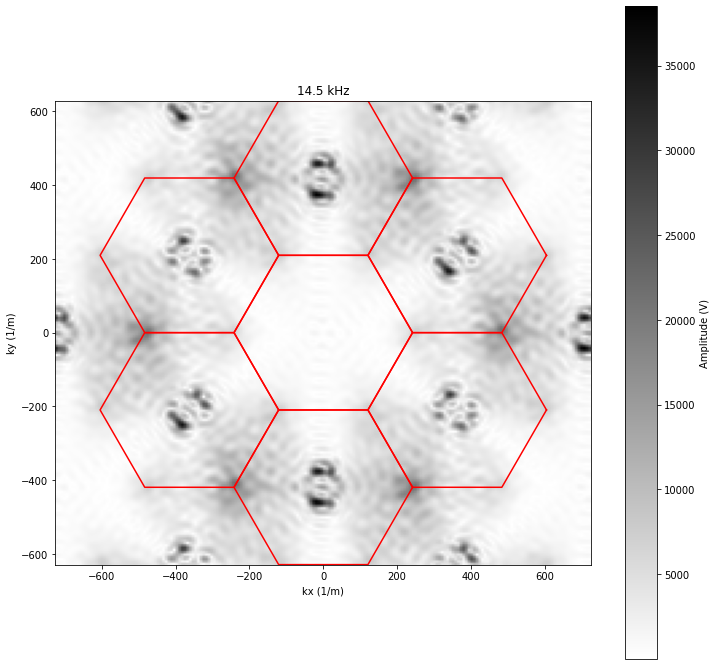

In [4]:
freq = 7.3
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-3*kxmax, 3*kxmax, -3*kymax, 3*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar(label="Amplitude (V)")

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz.png".format(freq))







"\nfor i in range(7):\n    plt.plot(xBZ[i], yBZ[i], 'r-')\n"

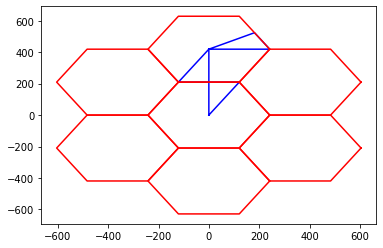

In [20]:
#GK'M'G sweeps

from tqdm import tqdm
import csv


freq_num = 650
freq_min = 2.0
freq_max = 17.0
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)
freq_div1 = 9.0
freq_div2 = 14.2

L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 300
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter

kxb_low = np.zeros(len(b))
kyb_low = np.zeros(len(b))
kxb_high = np.zeros(len(b))
kyb_high = np.zeros(len(b))
kxb_flat = np.zeros(len(b))
kyb_flat = np.zeros(len(b))


for i in range(len(b)):
    if b[i] < 1:
        kxb_low[i] = b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        kyb_low[i] = b[i] * 2 * np.pi / (3 * L)
        kxb_high[i] = -b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        kyb_high[i] = 4 * np.pi / (3 * L) - b[i] * 2 * np.pi / (3 * L)
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) * b[i]
        kyb_flat[i] = 4 * np.pi / (3 * L)
    elif b[i] < 1.5: 
        kxb_low[i] = 2 * np.pi / (np.sqrt(3)*3 * L) - 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_low[i] = 2 * np.pi / (3 * L) 
        kxb_high[i] = -2 * np.pi / (np.sqrt(3)*3 * L) + 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_high[i] = 2 * np.pi / (3 * L) 
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) - 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_flat[i] = 4 * np.pi / (3*L) + 2 * np.pi / (3 * L) * (b[i]-1)
    else:
        kxb_low[i] = 0
        kyb_low[i] = 2 * np.pi / (3 * L) - 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_high[i] = 0
        kyb_high[i] = 2 * np.pi / (3 * L) + 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_flat[i] = (1- (b[i] - 1.5) * 2 / np.sqrt(3)) * np.pi / (np.sqrt(3) * L)
        kyb_flat[i] = 4 * np.pi / (3*L) + (1- 2 / (np.sqrt(3)) * (b[i]-1.5)) * np.pi / (3 * L)
        
plt.figure()
plt.plot(kxb_flat, kyb_flat, 'b-')
plt.plot(kxb_high, kyb_high, 'b-')
plt.plot(kxb_low, kyb_low, 'b-')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')

'''
for i in range(7):
    plt.plot(xBZ[i], yBZ[i], 'r-')
'''

In [21]:
filename = '../../data/kagome_machine/preprocessed/'

reciprocal_data = np.zeros((freq_num, b_res))

    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f)
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_low[i] * (point[0]) + kyb_low[i] * (point[1]) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
                    
            elif values[j] <= freq_div2:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_high[i] * (point[0]) + kyb_high[i] * (point[1]) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
                    
            else:
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_flat[i] * (point[0]) + kyb_flat[i] * (point[1]) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude

            

100%|██████████| 650/650 [18:58<00:00,  1.75s/it]


In [35]:
reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]#/np.average(reciprocal_data[i])
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i][0]
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i].max()



folder = '../../data/kagome_machine/'

b_sim = []
band1 = []
band2 = []
band3 = []

with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))


    
# GKMG sweep
plt.figure(figsize = (10, 10))
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower')
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.colorbar()
plt.xlabel("GKMG sweep parameter")
plt.ylabel("Frequency (Hz)")
plt.savefig(folder + "fourier/figures/GK'M'G_sweep_1201")


plt.figure(figsize = (10, 10))
plt.imshow(np.log(reciprocal_data_plot), cmap = 'binary', extent = [b[0], b[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower')
plt.colorbar(label="Amplitude (V)")
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.xlabel("GKMG sweep parameter")
plt.ylabel("Frequency (Hz)")
plt.savefig(folder + "fourier/figures/GK'M'G_sweep_binary_1201")

ValueError: could not broadcast input array from shape (200) into shape (300)

In [ ]:
# Amplitude plot


from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

folder = "../../data/chirp_kagome_PVCcover_2-16kHz_0719/"
with open(folder + "preprocessed/_10024.048096192386_0.pkl",'rb') as f:
    real_data = pickle.load(f)  

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-5, 180)
ax.set_ylim(-5, 165)
ax.set_xlabel("x distance (mm)")
ax.set_ylabel("y distance (mm)")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=max_amp), cmap = "viridis"), ax=ax, label="Lock-in signal (V)")

    
for point in real_data:
    x_center = point[0]
    y_center = point[1]
    
    ampdata.append(point[2])
    phasedata.append(point[3])
    
    
    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.viridis(ampdata[-1]/max_amp),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])

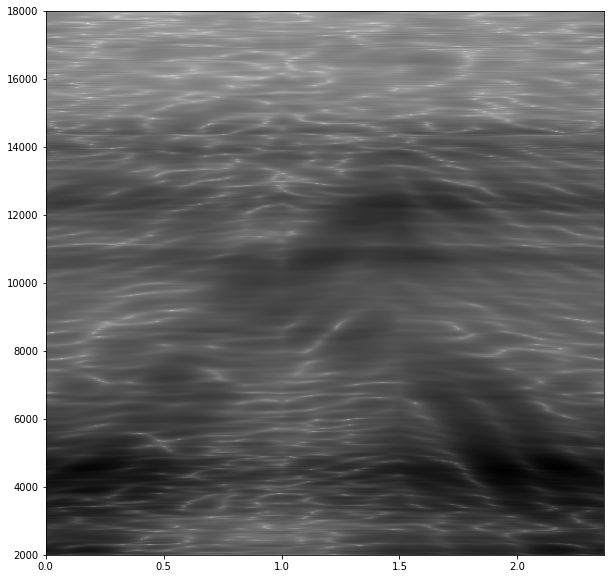

In [42]:
plt.figure(figsize = (10, 10))
plt.imshow(np.log(reciprocal_data), cmap = 'binary', extent = [b[0], b[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower')


100%|██████████| 500/500 [02:31<00:00,  3.29it/s]


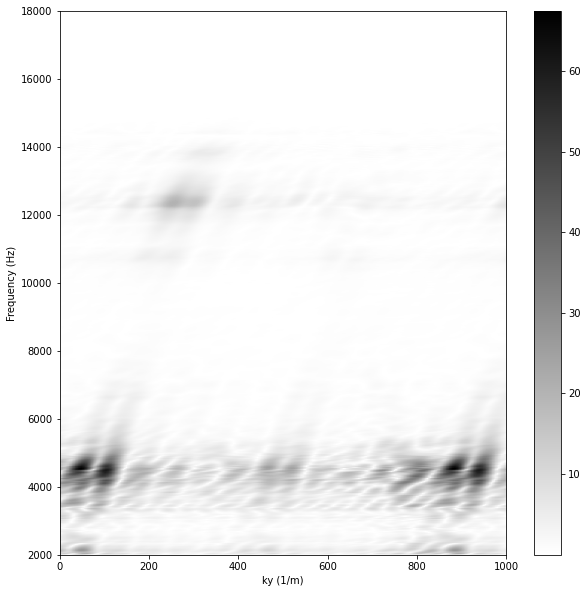

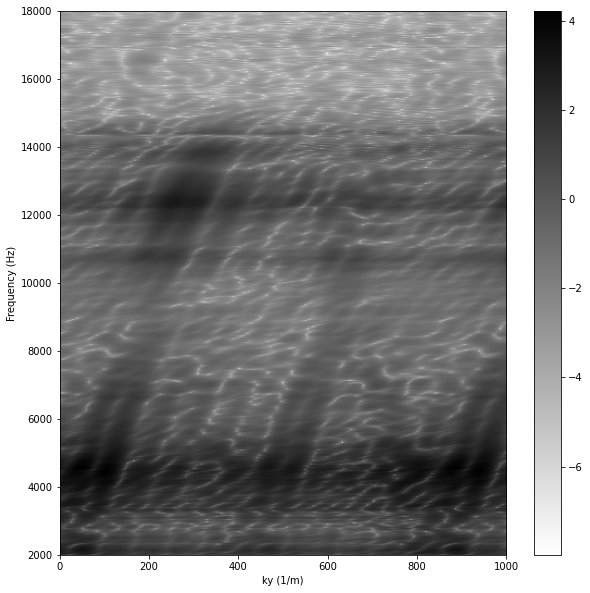

In [11]:
# y axis sweeps

from tqdm import tqdm


freq_num = 500
freq_min = 2000
freq_max = 18000
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)

L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 300
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter

kxb = np.zeros(len(b))
kyb = np.zeros(len(b))
kyb = np.linspace(0, 1000, b_res)



filename = '../../data/chirp_kagome_PLAcover_2-18kHz_0712/preprocessed/'

reciprocal_data = np.zeros((freq_num, b_res))

    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f)

            for i in range(b_res):
                amplitude = np.abs(np.array(
                        [point[2] * np.exp(-1j * (kxb[i] * (point[0] / 1000) + kyb[i] * (point[1] / 1000) + (point[3] / 57.2957795131))) 
                            for point in real_data]).sum())

                reciprocal_data[j][i] = amplitude

folder = '../../data/chirp_kagome_PLAcover_2-18kHz_0712/'


# y-axis sweep
plt.figure(figsize = (10, 10))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [kyb[0], kyb[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower')
plt.colorbar()
plt.xlabel("ky (1/m)")
plt.ylabel("Frequency (Hz)")
plt.savefig(folder + "fourier/figures/yaxis_sweep")
xBZ = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ = [0, kymax, kymax, 0, -kymax, -kymax, 0]
#plt.figure()
#plt.plot(xBZ, yBZ, 'r-')

plt.figure(figsize = (10, 10))
plt.imshow(np.log(reciprocal_data), cmap = 'binary', extent = [kyb[0], kyb[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower')
plt.colorbar()
plt.xlabel("ky (1/m)")
plt.ylabel("Frequency (Hz)")
plt.savefig(folder + "fourier/figures/yaxis_sweep_log")





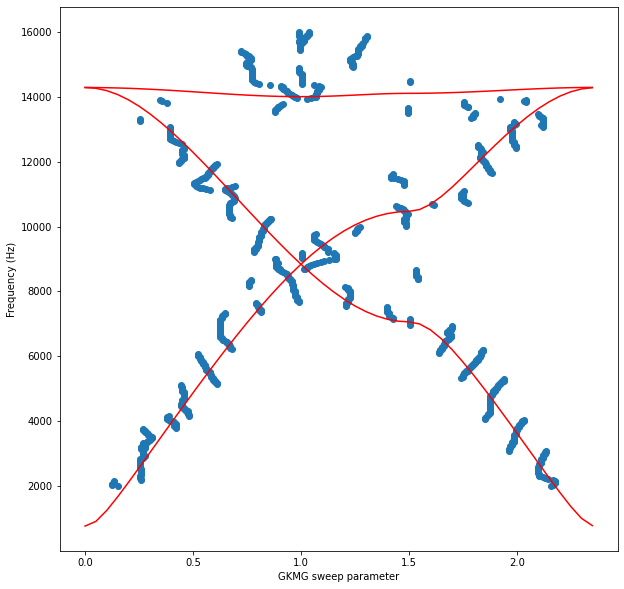

In [302]:
# Find peaks in the band structure and scatter them

from scipy.signal import find_peaks

peaks = []
peak_count = 2

freqs = np.linspace(freq_min, freq_max, freq_num)

scatterX = []
scatterY = []



for i in range(500): #214-428: 12-18 kHZ
    
    def peakValue(index):
        return reciprocal_data[i][index]

    peak_indices, _ = find_peaks(reciprocal_data[i])
    peak_indices = list(peak_indices)
    peak_indices.sort(key = peakValue, reverse = True)
    
    for j in range(peak_count):
        scatterX.append(b[peak_indices[j]])
        scatterY.append(freqs[i])

plt.figure(figsize=(10,10))
plt.plot(b_sim, band1, 'r-')
plt.plot(b_sim, band2, 'r-')
plt.plot(b_sim, band3, 'r-')
plt.scatter(scatterX, scatterY)
plt.xlabel("GKMG sweep parameter")
plt.ylabel("Frequency (Hz)")
plt.savefig(folder + "fourier/figures/GKMG_peaks_" + str(peak_count))

        
    

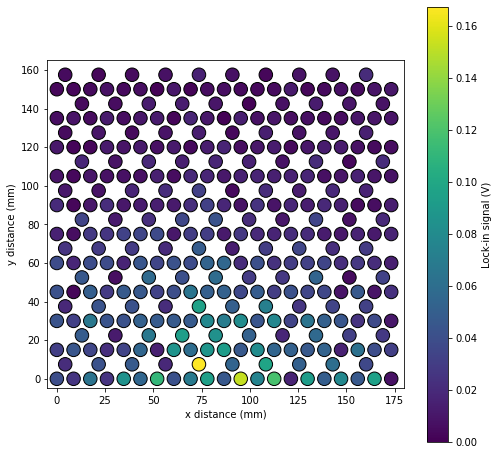

In [197]:
# Amplitude plot


from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

folder = "../../data/chirp_kagome_PVCcover_2-16kHz_0722/"
with open(folder + "preprocessed/_10024.048096192386_0.pkl",'rb') as f:
    real_data = pickle.load(f)  

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-5, 180)
ax.set_ylim(-5, 165)
ax.set_xlabel("x distance (mm)")
ax.set_ylabel("y distance (mm)")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=max_amp), cmap = "viridis"), ax=ax, label="Lock-in signal (V)")

    
for point in real_data:
    x_center = point[0]
    y_center = point[1]
    
    ampdata.append(point[2])
    phasedata.append(point[3])
    
    
    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.viridis(ampdata[-1]/max_amp),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])

plt.savefig(folder + "animations/amplitude_plot.png")

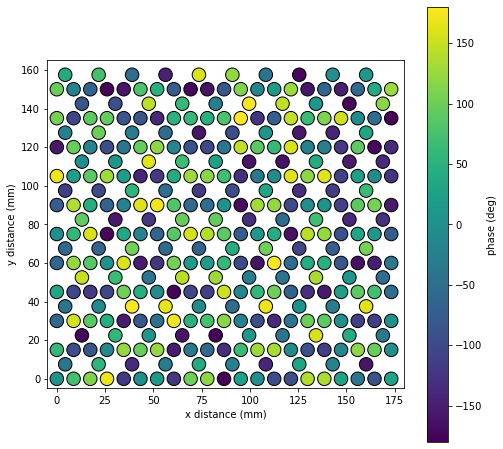

In [200]:
# Phase plot


from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

folder = "../../data/chirp_kagome_PVCcover_2-16kHz_0722/"
with open(folder + "preprocessed/_10024.048096192386_0.pkl",'rb') as f:
    real_data = pickle.load(f)  

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-5, 180)
ax.set_ylim(-5, 165)
ax.set_xlabel("x distance (mm)")
ax.set_ylabel("y distance (mm)")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-180, vmax=180), cmap = "viridis"), ax=ax, label="phase (deg)")

    
for point in real_data:
    x_center = point[0]
    y_center = point[1]
    
    ampdata.append(point[2])
    phasedata.append(point[3])
    
    
    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.viridis((phasedata[-1]+180)/360),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])
    
plt.savefig(folder + "animations/phase_plot.png")

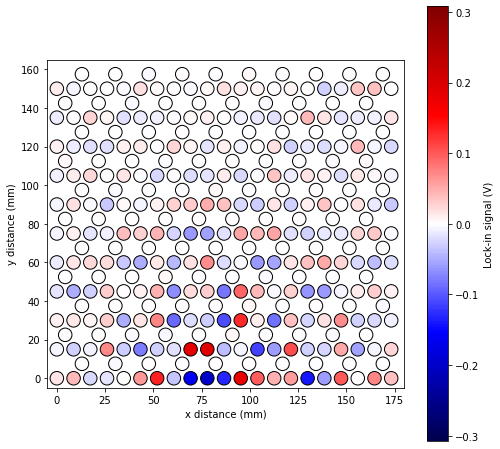

In [122]:
# Animating chirp scans

from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as colors


kagome_lattice = [((-0.8660,  0.0000), 0.35),
                ((-0.4330,  0.750), 0.35),
                (( 0.4330,  0.750), 0.35),
                (( 0.8660,  0.0000), 0.35),
                (( 0.4330, -0.750), 0.35),
                ((-0.4330, -0.750), 0.35)]


folder = "../../data/chirp_kagome_PVCcover_2-16kHz_0719/"

with open(folder + "preprocessed/_10024.048096192386_0.pkl",'rb') as f:
    real_data = pickle.load(f)    
    

lattice_offset = kagome_lattice[4][0]
unit_cell = 10.0
radius = kagome_lattice[0][1]*unit_cell

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-5, 180)
ax.set_ylim(-5, 165)
ax.set_xlabel("x distance (mm)")
ax.set_ylabel("y distance (mm)")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-max_amp, vmax=max_amp), cmap = "seismic"), ax=ax, label="Lock-in signal (V)")

cavities = []
ampdata = []
phasedata = []
t = 0
dt = 0.1

for point in real_data:
    x_center = point[0]
    y_center = point[1]
    
    ampdata.append(point[2])
    phasedata.append(point[3])
    
    pressure = ampdata[-1]*np.sin(np.deg2rad(phasedata[-1]))
    
    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])
    
def init():
    """initialize animation"""
    global cavities, t
    
    t = 0
    
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i])+t)
        
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities
    
def animate(j):
    global t, dt, cavities, ampdata, phasedata
    t += dt
                            
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i]+j))
        
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities

ani = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = True, init_func = init)


In [123]:
ani.save(folder + 'animations/10024kHz.gif', writer = 'imagemagick', fps = 60)

In [124]:
from IPython.display import HTML, Image

Image(url = folder + 'animations/10024kHz.gif')

Beginning chirp processing...
0
46
93
140
187
234
280
327
374
421
468
515
561
608
655
702
749
795
842
889
936
983
1030
1076
1123
1170
1217
1264
1311
1357
1404
1451
1498
1545
1591
1638
1685
1732
1779
1826
1872
1919
1966
2013
2060
2107
2153
2200
2247
2294
2341
2387
2434
2481
2528
2575
2622
2668
2715
2762
2809
2856
2903
2949
2996
3043
3090
3137
3183
3230
3277
3324
3371
3418
3464
3511
3558
3605
3652
3698
3745
3792
3839
3886
3933
3979
4026
4073
4120
4167
4214
4260
4307
4354
4401
4448
4494
4541
4588
4635
4682
4729
4775
4822
4869
4916
4963
5010
5056
5103
5150
5197
5244
5290
5337
5384
5431
5478
5525
5571
5618
5665
5712
5759
5806
5852
5899
5946
5993
6040
6086
6133
6180
6227
6274
6321
6367
6414
6461
6508
6555
6602
6648
6695
6742
6789
6836
6882
6929
6976
7023
7070
7117
7163
7210
7257
7304
7351
7397
7444
7491
7538
7585
7632
7678
7725
7772
7819
7866
7913
7959
8006
8053
8100
8147
8193
8240
8287
8334
8381
8428
8474
8521
8568
8615
8662
8709
8755
8802
8849
8896
8943
8989
9036
9083
9130
9177
9224
9270
9

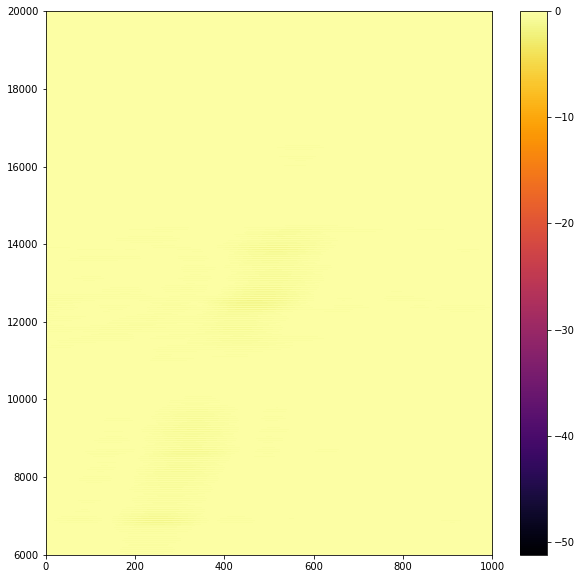

<Figure size 432x288 with 0 Axes>

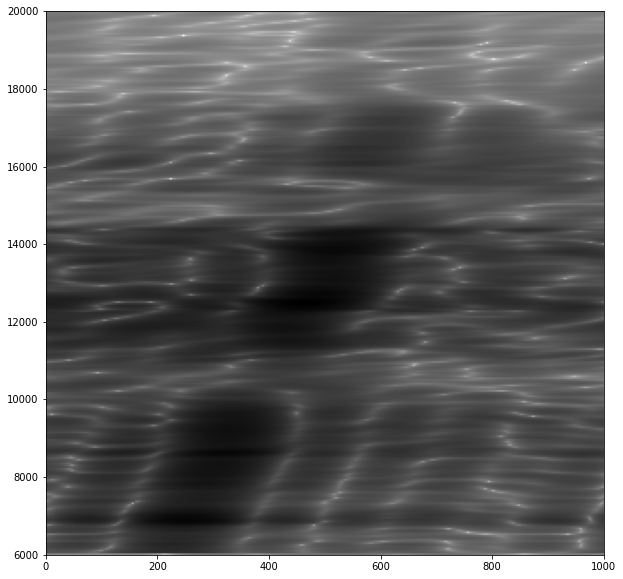

<Figure size 432x288 with 0 Axes>

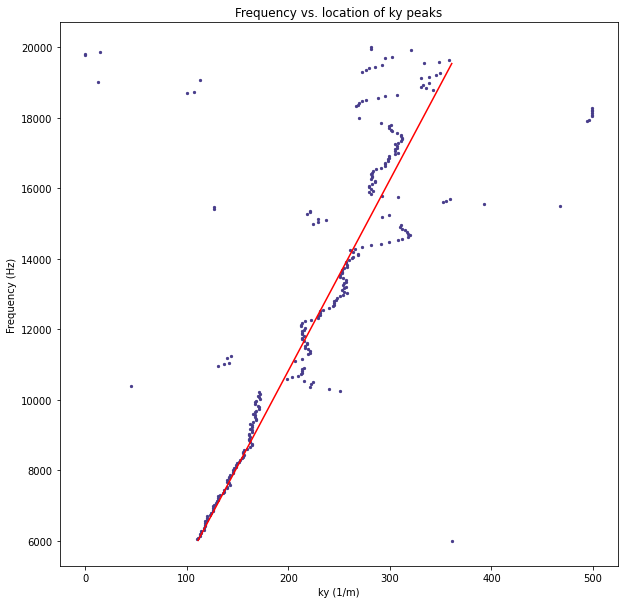

[7.93599242e+00 1.22028693e+04 3.13095092e+03]


<Figure size 432x288 with 0 Axes>

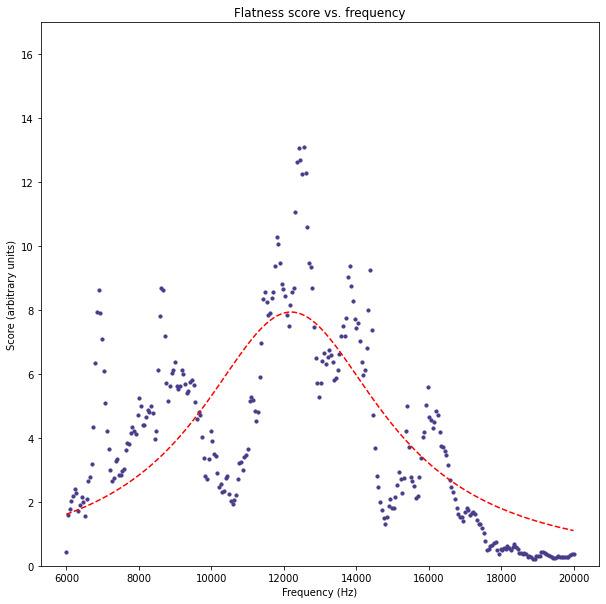

<Figure size 432x288 with 0 Axes>

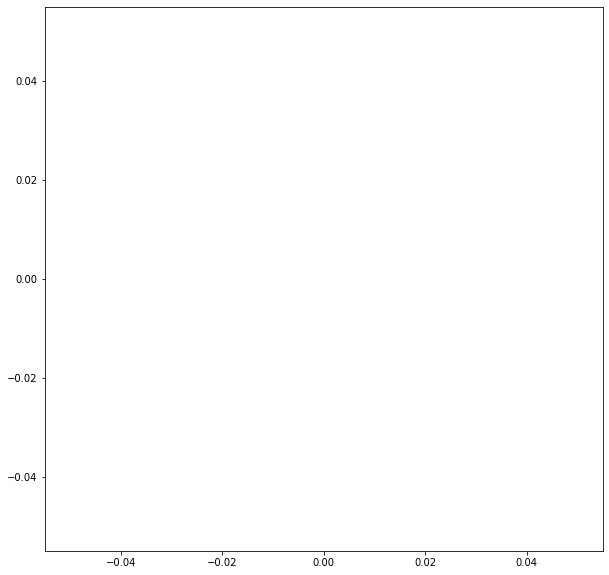

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [16]:
## STEP 3: COMBINE DATA

freqs = np.array([(0, np.linspace(6000, 20000, 300))], dtype=object)
    
proc.combine_data(size = (200, 200), 
                 freqs = freqs, 
                 kmin = 0, 
                 kmax = 1000, 
                 kmindisp = 0, 
                 kmaxdisp = 500,
                 ksamples = 701, 
                 filename = '../../data/chirp_extkag_6000-20000Hz_0624/fourier/',    ##CHANGE THIS
                 #datapath = '../../data/chirp_0621_final',       ##CHANGE THIS
                 figsize = (10, 10), 
                 tag = '_scpfdcal', 
                 dpi = 200,
                 cutoff = 1000.0,
                 rec_cutoff = -1000+81.0,
                 abs_cutoff = 1.5, 
                 meanp_cutoff = 1.5,
                 allplots = False, 
                 alplc = 0, 
                 alphc = 24072,
                 nimg = True, 
                 limg = True, 
                 scatter = True,
                 flatness_plot = True, 
                 normalize = False,
                 reconstruct = True,
                 flatness_peak_fit = True,
                 flatpeak_p0 = [25, 12200, 50],
                 flat_peak_start = 0, 
                 flat_peak_end = 15000)

In [135]:
with open('../../data/chirp_kagome_PVCcover_2-16kHz_0719/raw/scppos_4.33_22.5.pkl', 'rb') as f:
    data = pickle.load(f)
    
print(data[270])

[ 9.5751503e+03  1.4648500e-03 -1.1422800e+02]


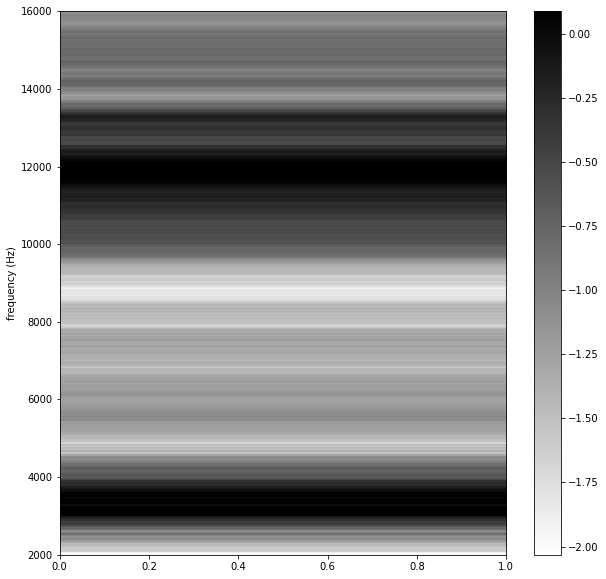

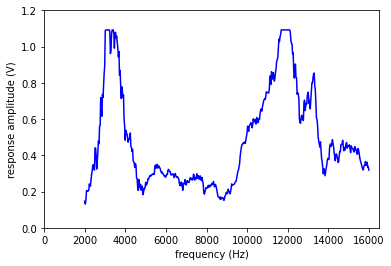

In [187]:
with open('../../data/chirp_kagome_PVCcover_2-16kHz_0719/frequencyResponse/freqResponse_dipper_newSpeaker_2000_16000_500.pkl', 'rb') as f:
    data = pickle.load(f)

freq, response = data

resp_plot = np.zeros((len(response),3))

for i in range(len(response)):
    for j in range(3):
        resp_plot[i][j] = response[i]
        
plt.figure(figsize = (10, 10))
plt.imshow(np.log(resp_plot), cmap = 'binary', extent = [0, 1, 2000, 16000], aspect = 'auto', origin = 'lower')
plt.colorbar()
plt.ylabel('frequency (Hz)')
plt.savefig("../../data/chirp_kagome_PVCcover_2-16kHz_0719/frequencyResponse/dipper_newSpeaker_colorPlot.png")

plt.figure()
plt.plot(freq, response, 'b-')
plt.axis([0, 16500, 0, 1.2])
plt.xlabel("frequency (Hz)")
plt.ylabel("response amplitude (V)")
plt.savefig("../../data/chirp_kagome_PVCcover_2-16kHz_0719/frequencyResponse/dipper_newSpeaker_plot.png")

In [162]:
data

[array([ 2000.        ,  2028.05611222,  2056.11222445,  2084.16833667,
         2112.2244489 ,  2140.28056112,  2168.33667335,  2196.39278557,
         2224.4488978 ,  2252.50501002,  2280.56112224,  2308.61723447,
         2336.67334669,  2364.72945892,  2392.78557114,  2420.84168337,
         2448.89779559,  2476.95390782,  2505.01002004,  2533.06613226,
         2561.12224449,  2589.17835671,  2617.23446894,  2645.29058116,
         2673.34669339,  2701.40280561,  2729.45891784,  2757.51503006,
         2785.57114228,  2813.62725451,  2841.68336673,  2869.73947896,
         2897.79559118,  2925.85170341,  2953.90781563,  2981.96392786,
         3010.02004008,  3038.0761523 ,  3066.13226453,  3094.18837675,
         3122.24448898,  3150.3006012 ,  3178.35671343,  3206.41282565,
         3234.46893788,  3262.5250501 ,  3290.58116232,  3318.63727455,
         3346.69338677,  3374.749499  ,  3402.80561122,  3430.86172345,
         3458.91783567,  3486.9739479 ,  3515.03006012,  3543.08